## Overview ##

This is a starter notebook inspired by last year's [Logistic Regression on Tournament Seeds by Kasper P. Lauritzen](https://www.kaggle.com/kplauritzen/notebookde27b18258?scriptVersionId=804590) starter kernel. It creates a basic logistic regression model based on the seed differences between teams. 

Note that the predictions for Stage 1's sample submissions file are already based on known outcomes, and the Tourney data this model is trained on includes that data. For Stage 2, you will be predicting future outcomes based on the teams selected for the tournament on March 11.

In [21]:
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


## Load the training data ##
We're keeping it simple & using only 2 files for this model: the Tourney seeds & Compact results.

In [22]:
data_dir = '../input/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_reg = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')
df_teams = pd.read_csv(data_dir + 'Teams.csv')

In [23]:
df_test = df_tour[df_tour.Season > 2013]

In [24]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [25]:
df_teams['YearsInD1'] = df_teams.LastD1Season - df_teams.FirstD1Season
df_teams['CurrentD1'] = df_teams.LastD1Season == 2018

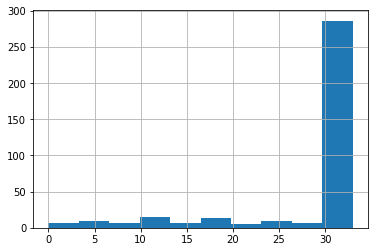

In [169]:
df_teams['YearsInD1'].hist()

In [26]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,YearsInD1,CurrentD1
0,1101,Abilene Chr,2014,2018,4,True
1,1102,Air Force,1985,2018,33,True
2,1103,Akron,1985,2018,33,True
3,1104,Alabama,1985,2018,33,True
4,1105,Alabama A&M,2000,2018,18,True


In [27]:
df_teams.shape

(364, 6)

In [28]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [29]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [30]:
# dropping 2014-2017 tournament from the training data
df_tour.drop(df_tour[df_tour.Season > 2013].index, inplace=True)

In [175]:
# trying to get number of tournament wins to get a sense of legacy
df_tour_wins = df_tour.groupby('WTeamID').count()
df_tour_wins.drop(labels=['LTeamID'], inplace=True, axis=1)
df_tour_wins.reset_index(inplace=True)
df_tour_wins.columns = ['TeamID','Wins']
df_tour_wins.head()

,TeamID,Wins
0,1104,18
1,1112,46
2,1113,5
3,1114,1
4,1115,1


In [196]:
df_teams = pd.merge(left=df_teams, right=df_tour_wins, how='left', on=['TeamID'])
df_teams.fillna(value={'Wins': 0}, inplace=True)
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,YearsInD1,CurrentD1,Wins_x,Wins_y,Wins
0,1101,Abilene Chr,2014,2018,4,True,NaN,NaN,0.0
1,1102,Air Force,1985,2018,33,True,NaN,NaN,0.0
2,1103,Akron,1985,2018,33,True,NaN,NaN,0.0
3,1104,Alabama,1985,2018,33,True,18.0,18.0,18.0
4,1105,Alabama A&M,2000,2018,18,True,NaN,NaN,0.0


In [33]:
df_reg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [34]:
df_reg.size

1205472

In [35]:
df_reg['ScoreDiff'] = df_reg['WScore'] - df_reg['LScore']
df_reg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreDiff
0,1985,20,1228,81,1328,64,N,0,17
1,1985,25,1106,77,1354,70,H,0,7
2,1985,25,1112,63,1223,56,H,0,7
3,1985,25,1165,70,1432,54,H,0,16
4,1985,25,1192,86,1447,74,H,0,12


In [305]:
df_reg_wins = pd.DataFrame()
df_reg_wins['ScoreDiff'] = df_reg['ScoreDiff']
df_reg_wins['TeamID'] = df_reg['WTeamID']
df_reg_wins['Season'] = df_reg['Season']
df_reg_wins['DayNum'] = df_reg['DayNum']

df_reg_losses = pd.DataFrame()
df_reg_losses['ScoreDiff'] = -df_reg['ScoreDiff']
df_reg_losses['TeamID'] = df_reg['LTeamID']
df_reg_losses['Season'] = df_reg['Season']
df_reg_losses['DayNum'] = df_reg['DayNum']

df_reg_scorediff = pd.concat((df_reg_wins, df_reg_losses))
df_reg_scorediff.head()

,ScoreDiff,TeamID,Season,DayNum
0,17,1228,1985,20
1,7,1106,1985,25
2,7,1112,1985,25
3,16,1165,1985,25
4,12,1192,1985,25


In [316]:
df_reg_scorediff.columns

Index([u'ScoreDiff', u'TeamID', u'Season', u'DayNum'], dtype='object')

In [371]:
last5games = df_reg_scorediff.sort_values(['Season','TeamID','DayNum']).groupby(['Season','TeamID']).tail(5)
last5games

,ScoreDiff,TeamID,Season,DayNum
3157,4,1102,1985,117
3321,-2,1102,1985,120
3404,-1,1102,1985,122
3563,3,1102,1985,126
3606,-2,1102,1985,127
2780,-2,1103,1985,107
2875,3,1103,1985,110
3001,14,1103,1985,112
3254,-22,1103,1985,117
3306,-8,1103,1985,119


In [372]:
df_last5AvgScoreDiff = last5games.groupby(['Season','TeamID'], as_index=False).mean()
df_last5AvgScoreDiff.drop(labels=['DayNum'], inplace=True, axis=1)
df_last5AvgScoreDiff

,Season,TeamID,ScoreDiff
0,1985,1102,0.4
1,1985,1103,-3.0
2,1985,1104,11.0
3,1985,1106,-1.0
4,1985,1108,2.4
5,1985,1109,-29.4
6,1985,1110,-5.8
7,1985,1111,-1.6
8,1985,1112,5.2
9,1985,1113,-8.4


In [373]:
df_avgScoreDiff = df_reg_scorediff.groupby(['Season','TeamID'], as_index=False).mean()
df_avgScoreDiff.tail()

,Season,TeamID,ScoreDiff,DayNum
10532,2017,1460,1.400000,68.566667
10533,2017,1461,0.566667,71.566667
10534,2017,1462,3.264706,73.088235
10535,2017,1463,2.392857,74.071429
10536,2017,1464,-7.187500,70.531250


First, we'll simplify the datasets to remove the columns we won't be using and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

In [374]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

AttributeError: 'DataFrame' object has no attribute 'Seed'

In [375]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

ValueError: labels ['DayNum' 'WScore' 'LScore' 'WLoc' 'NumOT'] not contained in axis

Features to add
- Region
- Last 10 regular 10 games
- Public Rankings
- Point spread across players


## Merge seed for each team ##
Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [376]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, how='left', on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed

df_winavgscorediff = df_avgScoreDiff.rename(columns={'TeamID':'WTeamID', 'ScoreDiff':'WAvgScoreDiff'})
df_lossavgscorediff = df_avgScoreDiff.rename(columns={'TeamID':'LTeamID', 'ScoreDiff':'LAvgScoreDiff'})
df_dummy = pd.merge(left=df_concat, right=df_winavgscorediff, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossavgscorediff, how='left', on=['Season', 'LTeamID'])
df_concat['ScoreDiffDiff'] = df_concat.WAvgScoreDiff - df_concat.LAvgScoreDiff

df_winlast5avgscorediff = df_last5AvgScoreDiff.rename(columns={'TeamID':'WTeamID', 'ScoreDiff':'WLast5AvgScoreDiff'})
df_losslast5avgscorediff = df_last5AvgScoreDiff.rename(columns={'TeamID':'LTeamID', 'ScoreDiff':'LLast5AvgScoreDiff'})
df_dummy = pd.merge(left=df_concat, right=df_winlast5avgscorediff, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_losslast5avgscorediff, how='left', on=['Season', 'LTeamID'])
df_concat['Last5ScoreDiffDiff'] = df_concat.WLast5AvgScoreDiff - df_concat.LLast5AvgScoreDiff

df_winTourWins = df_teams.rename(columns={'TeamID':'WTeamID', 'Wins':'WTourWins'})
df_lossTourWins = df_teams.rename(columns={'TeamID':'LTeamID', 'Wins':'LTourWins'})
df_dummy = pd.merge(left=df_concat, right=df_winTourWins, how='left', on=['WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossTourWins, how='left', on=['LTeamID'])
df_concat['TourWinDiff'] = df_concat.WTourWins - df_concat.LTourWins
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff,WAvgScoreDiff,DayNum_x,LAvgScoreDiff,DayNum_y,...,WTourWins,TeamName_y,FirstD1Season_y,LastD1Season_y,YearsInD1_y,CurrentD1_y,Wins_x_y,Wins_y_y,LTourWins,TourWinDiff
0,1985,1116,1234,9,8,1,3.636364,79.606061,10.466667,76.566667,...,28.0,Iowa,1985,2018,33,True,14.0,14.0,14.0,14.0
1,1985,1120,1345,11,6,5,3.689655,87.275862,3.800000,83.280000,...,12.0,Purdue,1985,2018,33,True,26.0,26.0,26.0,-14.0
2,1985,1207,1250,1,16,-15,15.666667,86.740741,-4.448276,80.862069,...,32.0,Lehigh,1985,2018,33,True,1.0,1.0,1.0,31.0
3,1985,1229,1425,9,8,1,5.962963,79.814815,3.785714,82.464286,...,2.0,USC,1985,2018,33,True,7.0,7.0,7.0,-5.0
4,1985,1242,1325,3,14,-11,5.633333,82.666667,4.555556,83.925926,...,72.0,Ohio,1985,2018,33,True,3.0,3.0,3.0,69.0


Now we'll create a dataframe that summarizes wins & losses along with their corresponding seed differences. This is the meat of what we'll be creating our model on.

In [377]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['ScoreDiffDiff'] = df_concat['ScoreDiffDiff']
df_wins['Last5ScoreDiffDiff'] = df_concat['Last5ScoreDiffDiff']
df_wins['TourWinDiff'] = df_concat['TourWinDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['ScoreDiffDiff'] = -df_concat['ScoreDiffDiff']
df_losses['Last5ScoreDiffDiff'] = -df_concat['Last5ScoreDiffDiff']
df_losses['TourWinDiff'] = -df_concat['TourWinDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.tail()

,SeedDiff,ScoreDiffDiff,Last5ScoreDiffDiff,TourWinDiff,Result
1844,1,-2.713235,-9.4,39.0,0
1845,-1,6.501894,7.6,5.0,0
1846,8,-6.852941,-14.6,-37.0,0
1847,0,-0.180357,-6.8,14.0,0
1848,3,-4.150735,-13.4,-10.0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23a27290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a267876d0>]], dtype=object)

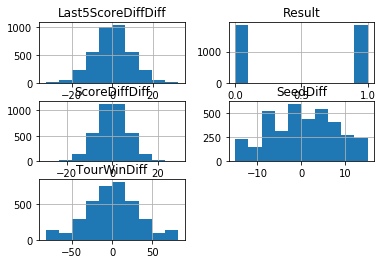

In [378]:
df_predictions.hist()

In [379]:
#X_train = df_predictions.SeedDiff.values.reshape(-1,1)
X_train = df_predictions[['SeedDiff','ScoreDiffDiff','Last5ScoreDiffDiff','TourWinDiff']]
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the model ##
Use a basic logistic regression to train the model. You can set different C values to see how performance changes.

In [380]:
X_train.head()

,SeedDiff,ScoreDiffDiff,Last5ScoreDiffDiff,TourWinDiff
743,11,-8.564583,-9.0,17.0
602,8,-3.670034,-13.8,18.0
998,4,-5.996663,-8.4,63.0
1002,-2,3.836485,-0.4,5.0
792,-7,13.122257,3.0,51.0


In [340]:
import xgboost as xgb

# couldn't get the conversion to matrix to work...
#X_train_matrix = xgb.DMatrix(X_train.values)
#y_train_matrix = xgb.DMatrix(y_train)

#gbm = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
gbm = xgb.XGBClassifier(n_estimators=300)
params = {'max_depth': [2,3,5,10,50], 'learning_rate': [0.01, 0.05, 0.1, 0.5]}
clf = GridSearchCV(gbm, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best max_depth: {}, with best learning rate: {}'.format(clf.best_score_, clf.best_params_['max_depth'], clf.best_params_['learning_rate']))

Best log_loss: -0.5353, with best max_depth: 3, with best learning rate: 0.01


In [212]:
# Fine tune it some more...
gbm = xgb.XGBClassifier(n_estimators=300)
params = {'max_depth': [3,4,5], 'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]}
clf = GridSearchCV(gbm, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best max_depth: {}, with best learning rate: {}'.format(clf.best_score_, clf.best_params_['max_depth'], clf.best_params_['learning_rate']))

Best log_loss: -0.5337, with best max_depth: 3, with best learning rate: 0.02


In [413]:
gbm = xgb.XGBClassifier(n_estimators=300)
params = {'max_depth': [2,3,5,10,50], 'learning_rate': [0.01, 0.05, 0.1, 0.5]}
clf = GridSearchCV(gbm, params, scoring='accuracy', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best max_depth: {}, with best learning rate: {}'.format(clf.best_score_, clf.best_params_['max_depth'], clf.best_params_['learning_rate']))

Best log_loss: 0.7274, with best max_depth: 5, with best learning rate: 0.01


In [48]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5423, with best C: 0.01


Plotting validates our intuition, that the probability a team will win decreases as the seed differential to its opponent decreases.

In [414]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [415]:
X_test = np.zeros(shape=(n_test_games, 4))
df_sample_sub_split = pd.DataFrame(columns=['year','t1','t2'])
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    df_sample_sub_split.loc[ii] = pd.Series({'year':year, 't1':t1, 't2':t2})
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    t1_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == t1) & (df_avgScoreDiff.Season == year)].ScoreDiff.values[0]
    t2_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == t2) & (df_avgScoreDiff.Season == year)].ScoreDiff.values[0]
    t1_last5_avg_score_diff = df_last5AvgScoreDiff[(df_last5AvgScoreDiff.TeamID == t1) & (df_last5AvgScoreDiff.Season == year)].ScoreDiff.values[0]
    t2_last5_avg_score_diff = df_last5AvgScoreDiff[(df_last5AvgScoreDiff.TeamID == t2) & (df_last5AvgScoreDiff.Season == year)].ScoreDiff.values[0]
    t1_tour_wins = df_teams[df_teams.TeamID == t1].Wins.values[0]
    t2_tour_wins = df_teams[df_teams.TeamID == t2].Wins.values[0]
    diff_seed = t1_seed - t2_seed
    score_diffdiff = t1_avg_score_diff - t2_avg_score_diff
    last5_score_diffdiff = t1_last5_avg_score_diff - t2_last5_avg_score_diff
    tourwins_diff = t1_tour_wins - t2_tour_wins
    X_test[ii, 0] = diff_seed
    X_test[ii, 1] = score_diffdiff 
    X_test[ii, 2] = last5_score_diffdiff 
    X_test[ii, 3] = tourwins_diff 

In [416]:
X_test_DF = pd.DataFrame(X_test, columns=['SeedDiff','ScoreDiffDiff','Last5ScoreDiffDiff','TourWinDiff'])

In [417]:
X_test_DF.head()

,SeedDiff,ScoreDiffDiff,Last5ScoreDiffDiff,TourWinDiff
0,1.0,-3.125000,3.6,0.0
1,15.0,-12.724265,3.0,-46.0
2,6.0,-3.968750,12.2,-5.0
3,10.0,-3.206439,7.6,-6.0
4,6.0,-4.479167,6.8,-7.0


## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [418]:
from sklearn.ensemble import RandomForestClassifier

#preds = clf.predict_proba(X_test)[:,1]
#gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.02).fit(X_train, y_train)
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01).fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
preds = rfc.predict_proba(X_test_DF)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.60
1,2014_1107_1112,0.05
2,2014_1107_1113,0.30
3,2014_1107_1124,0.40
4,2014_1107_1140,0.20


Lastly, create your submission file!

In [419]:
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)

## Do my own validation

In [420]:
df_sample_sub_rev = pd.DataFrame(columns=['ID','Pred'])
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    df_sample_sub_rev.loc[ii] = pd.Series({'ID':str(year)+'_'+str(t2)+'_'+str(t1), 'Pred': 1 - row.Pred})
    
df_sample_sub.set_index('ID', inplace=True)
df_sample_sub_rev.set_index('ID', inplace=True)

df_sample_sub = df_sample_sub.append(df_sample_sub_rev)

0.712686567164


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2465ead0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a269b0990>]], dtype=object)

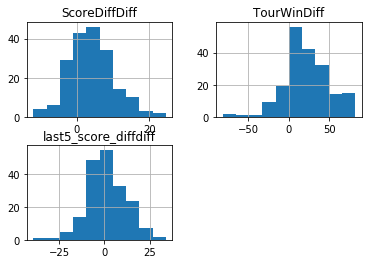

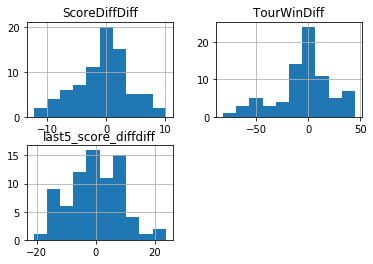

In [421]:
predCorrect = 0
correctDF = pd.DataFrame(columns=['SeedDiff', 'ScoreDiffDiff','last5_score_diffdiff','TourWinDiff'])
incorrectDF = pd.DataFrame(columns=['SeedDiff', 'ScoreDiffDiff','last5_score_diffdiff','TourWinDiff'])
for index, game in df_test.iterrows():
    gameID = str(game.Season) + "_" + str(game.WTeamID) + "_" + str(game.LTeamID)
    t1_seed = df_seeds[(df_seeds.TeamID == game.WTeamID) & (df_seeds.Season == game.Season)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == game.LTeamID) & (df_seeds.Season == game.Season)].seed_int.values[0]
    t1_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == game.WTeamID) & (df_avgScoreDiff.Season == game.Season)].ScoreDiff.values[0]
    t2_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == game.LTeamID) & (df_avgScoreDiff.Season == game.Season)].ScoreDiff.values[0]
    t1_last5_avg_score_diff = df_last5AvgScoreDiff[(df_last5AvgScoreDiff.TeamID == game.WTeamID) & (df_last5AvgScoreDiff.Season == game.Season)].ScoreDiff.values[0]
    t2_last5_avg_score_diff = df_last5AvgScoreDiff[(df_last5AvgScoreDiff.TeamID == game.LTeamID) & (df_last5AvgScoreDiff.Season == game.Season)].ScoreDiff.values[0]
    t1_tour_wins = df_teams[df_teams.TeamID == game.WTeamID].Wins.values[0]
    t2_tour_wins = df_teams[df_teams.TeamID == game.LTeamID].Wins.values[0]
    diff_seed = t1_seed - t2_seed
    score_diffdiff = t1_avg_score_diff - t2_avg_score_diff
    last5_score_diffdiff = t1_last5_avg_score_diff - t2_last5_avg_score_diff
    tourwins_diff = t1_tour_wins - t2_tour_wins

    if df_sample_sub['Pred'][gameID] >= 0.5:
        predCorrect += 1
        correctDF = correctDF.append(pd.DataFrame([[diff_seed, score_diffdiff, last5_score_diffdiff, tourwins_diff]], columns=['SeedDiff', 'ScoreDiffDiff','last5_score_diffdiff','TourWinDiff']), ignore_index=True)
    else:
        incorrectDF = incorrectDF.append(pd.DataFrame([[diff_seed, score_diffdiff, last5_score_diffdiff, tourwins_diff]], columns=['SeedDiff', 'ScoreDiffDiff','last5_score_diffdiff','TourWinDiff']), ignore_index=True)

print(1.0*predCorrect/268)
correctDF.hist()
incorrectDF.hist()

In [422]:
correctDF.SeedDiff.value_counts()

-1     20
-8     18
-3     18
-9     17
-15    16
-13    15
-7     14
-11    12
-5     12
 0     11
-4      9
 5      7
 7      6
 1      5
 3      3
-6      2
-2      2
-10     1
 8      1
 6      1
 4      1
Name: SeedDiff, dtype: int64

In [423]:
incorrectDF.SeedDiff.value_counts()

 0     9
 5     9
 1     8
 3     7
-3     6
-1     6
 11    4
-8     4
-7     4
 8     3
 7     3
 4     3
 9     3
 6     2
-9     1
-10    1
 13    1
-5     1
 2     1
-4     1
Name: SeedDiff, dtype: int64

## current best: 0.716417910448

In [ ]:
# NOT Implemented
# ROC Curve
from sklearn.metrics import roc_curve
pred = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, pred)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')